In [1]:
import pandas as pd
import numpy as np

In [2]:
import os
import sys

root_folder = os.path.dirname(os.path.abspath(os.getcwd()))
fetching_data_module_folder = root_folder + "\\fetch_data"

sys.path.insert(0, fetching_data_module_folder)

from fetching_satellite_based import remote_sensing_factor_df

In [3]:
ndvi_df = remote_sensing_factor_df(factor='NDVI', begin=2001, end=2021)
ndvi_df.sort_values(by=['date', 'ID'])
ndvi_df

,lon,lat,date,ID,NDVI
0,105.850899,21.021299,2001-01-01,5,0.056508
365,105.741867,21.049749,2001-01-01,19,0.108181
730,105.948544,21.200344,2001-01-01,51,0.245045
1095,106.288330,21.123247,2001-01-01,52,0.149046
1460,106.111371,21.152745,2001-01-01,53,0.189471
...,...,...,...,...,...
8029,106.314003,20.927000,2021-12-31,172,0.001342
8394,106.430801,20.977400,2021-12-31,173,0.010294
8759,106.385597,21.116400,2021-12-31,175,0.011048
9124,105.367302,21.338470,2021-12-31,195,-0.003163


In [4]:
from linear_weighted_moving_average import lwmv_imputation

imputed_ndvi_df = lwmv_imputation(df = ndvi_df, factors=['NDVI'])

imputed_ndvi_df

,lon,lat,date,ID,NDVI
0,105.850899,21.021299,2001-01-01,5,0.056508
1,105.850899,21.021299,2001-01-02,5,0.010700
2,105.850899,21.021299,2001-01-03,5,-0.004222
3,105.850899,21.021299,2001-01-04,5,-0.001730
4,105.850899,21.021299,2001-01-05,5,-0.002398
...,...,...,...,...,...
9485,105.853941,21.023532,2021-12-27,300,0.001190
9486,105.853941,21.023532,2021-12-28,300,0.010594
9487,105.853941,21.023532,2021-12-29,300,-0.005183
9488,105.853941,21.023532,2021-12-30,300,0.015569


In [5]:
imputed_ndvi_df.to_csv('ndvi_imputed.csv', index=False)

# Phân tích phân bố xác suất của NDVI trước và sau khi điền khuyết

Phần dưới đây sẽ trực quan hóa phân bố xác suất của giá trị NDVI trước và sau khi áp dụng phương pháp Linear Weighted Moving Average để điền khuyết dữ liệu. Qua đó đánh giá được hiệu quả của phương pháp và ảnh hưởng của việc điền khuyết đến phân phối tổng thể của dữ liệu.

In [14]:
# Import thư viện trực quan hóa dữ liệu nâng cao
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib as mpl
from matplotlib.ticker import PercentFormatter

# Thiết lập style cho đẹp hơn
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_palette('viridis')
mpl.rcParams['font.family'] = 'sans-serif'
mpl.rcParams['font.sans-serif'] = ['Arial', 'DejaVu Sans']
mpl.rcParams['axes.titlesize'] = 16
mpl.rcParams['axes.labelsize'] = 13
mpl.rcParams['xtick.labelsize'] = 11
mpl.rcParams['ytick.labelsize'] = 11

# Tính toán thống kê về dữ liệu thiếu
original_total = len(ndvi_df)
original_missing = ndvi_df['NDVI'].isna().sum()
original_missing_percent = round(original_missing / original_total * 100, 2)
original_present = original_total - original_missing
original_present_percent = round(100 - original_missing_percent, 2)

imputed_total = len(imputed_ndvi_df)
imputed_missing = imputed_ndvi_df['NDVI'].isna().sum()
imputed_missing_percent = round(imputed_missing / imputed_total * 100, 2)
imputed_present = imputed_total - imputed_missing
imputed_present_percent = round(100 - imputed_missing_percent, 2)

print(f"Dữ liệu ban đầu: {original_missing:,} giá trị thiếu ({original_missing_percent}%)")
print(f"Dữ liệu sau khi điền khuyết: {imputed_missing:,} giá trị thiếu ({imputed_missing_percent}%)")
print(f"Số lượng giá trị đã được điền khuyết: {original_missing - imputed_missing:,} ({round((original_missing - imputed_missing)/original_missing*100, 2)}% số giá trị thiếu)")

Dữ liệu ban đầu: 18,387 giá trị thiếu (9.22%)
Dữ liệu sau khi điền khuyết: 568 giá trị thiếu (0.28%)
Số lượng giá trị đã được điền khuyết: 17,819 (96.91% số giá trị thiếu)


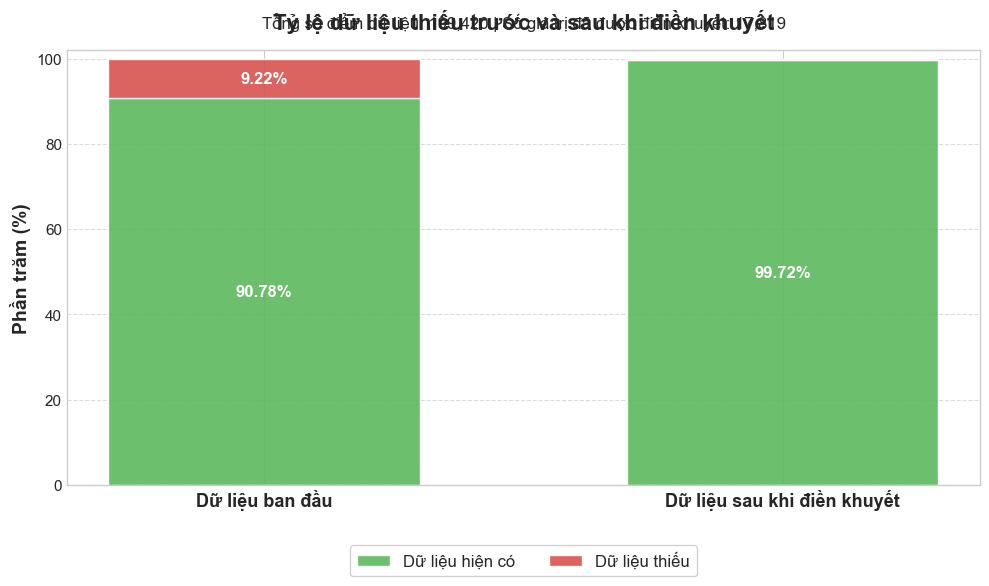

In [15]:
# Biểu đồ cột thể hiện tỷ lệ dữ liệu thiếu
fig, ax = plt.subplots(figsize=(10, 6))

labels = ['Dữ liệu ban đầu', 'Dữ liệu sau khi điền khuyết']
present_values = [original_present_percent, imputed_present_percent]
missing_values = [original_missing_percent, imputed_missing_percent]

x = np.arange(len(labels))
width = 0.6

# Tạo biểu đồ cột xếp chồng
p1 = ax.bar(x, present_values, width, label='Dữ liệu hiện có', color='#5cb85c', alpha=0.9)
p2 = ax.bar(x, missing_values, width, bottom=present_values, label='Dữ liệu thiếu', color='#d9534f', alpha=0.9)

# Thêm nhãn giá trị trên mỗi cột
for i, v in enumerate(present_values):
    ax.text(i, v/2, f"{v}%", ha='center', va='center', color='white', fontweight='bold', fontsize=12)

for i, v in enumerate(missing_values):
    if v > 2:  # Chỉ hiển thị nhãn nếu đủ không gian
        ax.text(i, present_values[i] + v/2, f"{v}%", ha='center', va='center', color='white', fontweight='bold', fontsize=12)

# Tùy chỉnh trục và tiêu đề
ax.set_ylabel('Phần trăm (%)', fontweight='bold', fontsize=14)
ax.set_title('Tỷ lệ dữ liệu thiếu trước và sau khi điền khuyết', fontweight='bold', fontsize=16, pad=15)
ax.set_xticks(x)
ax.set_xticklabels(labels, fontweight='bold', fontsize=13)
ax.set_ylim(0, 102)  # Đảm bảo đủ không gian cho nhãn phía trên
ax.yaxis.grid(True, linestyle='--', alpha=0.7)

# Thêm chú thích chi tiết về số liệu
ax.text(0.5, 1.05, f'Tổng số điểm dữ liệu: {original_total:,} | Số giá trị đã được điền khuyết: {original_missing - imputed_missing:,}', 
        horizontalalignment='center', fontsize=12, transform=ax.transAxes)

# Tạo chú thích và đặt ở dưới biểu đồ
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.12), ncol=2, fontsize=12, frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


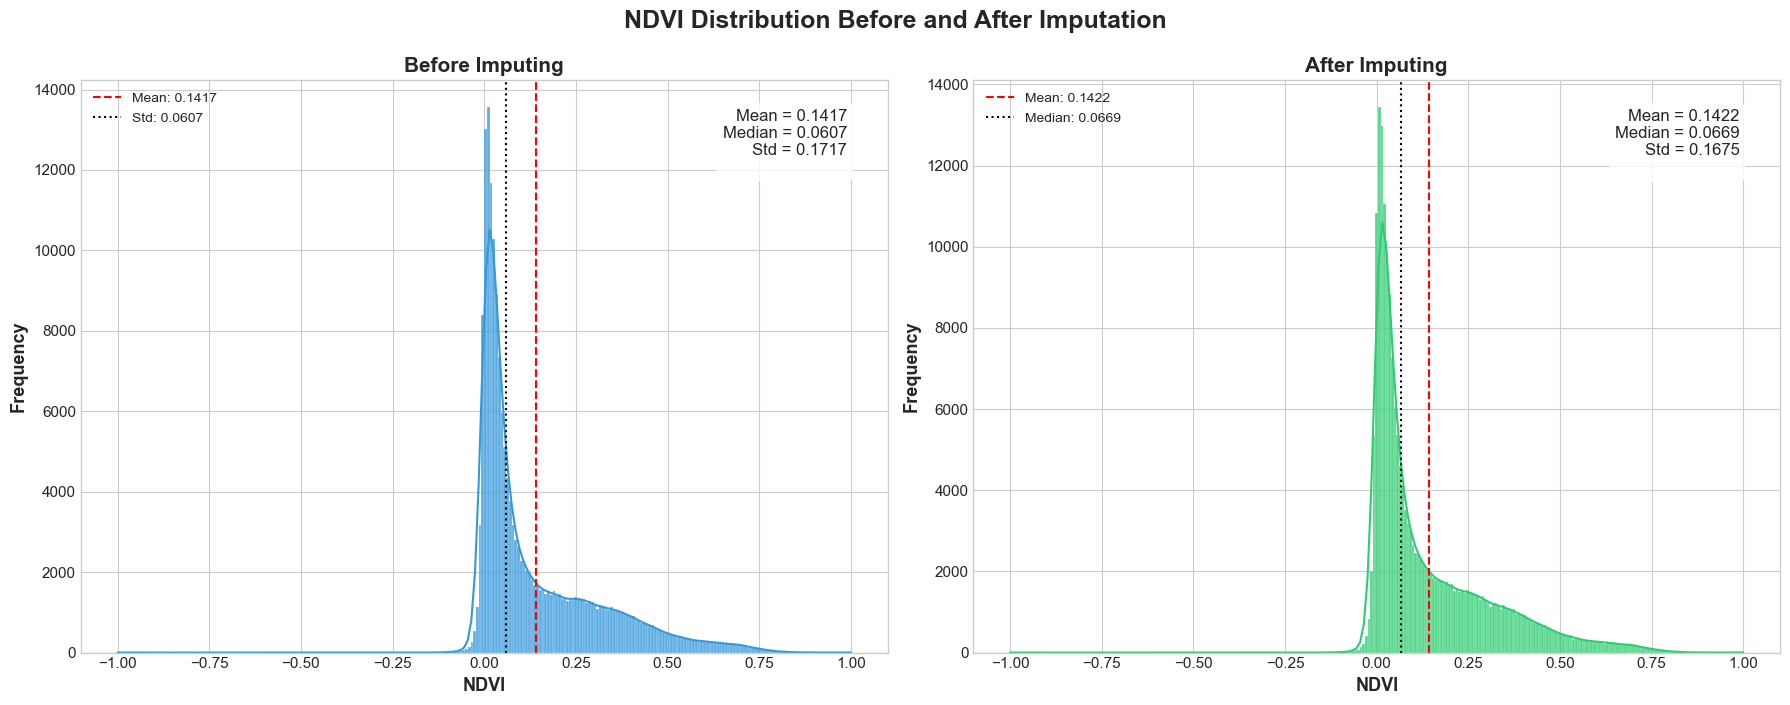

In [19]:
# Định nghĩa các màu đẹp hơn cho biểu đồ
original_color = '#3498db'  # Xanh dương
imputed_color = '#2ecc71'   # Xanh lá

# Tạo figure với 2 subplots cải tiến
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(18, 7))
fig.suptitle('NDVI Distribution Before and After Imputation', fontsize=18, fontweight='bold', y=1)

# Tính các giá trị thống kê cho dữ liệu gốc
orig_mean = ndvi_df['NDVI'].mean()
orig_median = ndvi_df['NDVI'].median()
orig_std = ndvi_df['NDVI'].std()

# Subplot 1: Histogram trước khi điền khuyết với các chỉ số thống kê
sns.histplot(ndvi_df['NDVI'].dropna(), kde=True, color=original_color, alpha=0.8, ax=ax1)
ax1.set_title('Before Imputing', fontweight='bold', fontsize=15)
ax1.set_xlabel('NDVI', fontweight='bold')
ax1.set_ylabel('Frequency', fontweight='bold')

# Thêm đường vertical line cho giá trị trung bình và trung vị
ax1.axvline(x=orig_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {orig_mean:.4f}')
ax1.axvline(x=orig_median, color='black', linestyle=':', linewidth=1.5, label=f'Std: {orig_median:.4f}')

# Thêm thông tin thống kê lên biểu đồ 1
stats_text = f"Mean = {orig_mean:.4f}\n" \
           f"Median = {orig_median:.4f}\n" \
           f"Std = {orig_std:.4f}\n" \

ax1.text(0.95, 0.95, stats_text, transform=ax1.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax1.legend(loc='upper left', fontsize=10)

# Tính các giá trị thống kê cho dữ liệu đã điền khuyết
imp_mean = imputed_ndvi_df['NDVI'].mean()
imp_median = imputed_ndvi_df['NDVI'].median()
imp_std = imputed_ndvi_df['NDVI'].std()

# Subplot 2: Histogram sau khi điền khuyết với các chỉ số thống kê
sns.histplot(imputed_ndvi_df['NDVI'].dropna(), kde=True, color=imputed_color, alpha=0.8, ax=ax2)
ax2.set_title('After Imputing', fontweight='bold', fontsize=15)
ax2.set_xlabel('NDVI', fontweight='bold')
ax2.set_ylabel('Frequency', fontweight='bold')

# Thêm đường vertical line cho giá trị trung bình và trung vị
ax2.axvline(x=imp_mean, color='red', linestyle='--', linewidth=1.5, label=f'Mean: {imp_mean:.4f}')
ax2.axvline(x=imp_median, color='black', linestyle=':', linewidth=1.5, label=f'Median: {imp_median:.4f}')

# Thêm thông tin thống kê lên biểu đồ 2
stats_text = f"Mean = {imp_mean:.4f}\n" \
           f"Median = {imp_median:.4f}\n" \
           f"Std = {imp_std:.4f}\n" \

ax2.text(0.95, 0.95, stats_text, transform=ax2.transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='right',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))
ax2.legend(loc='upper left', fontsize=10)

plt.tight_layout()
plt.subplots_adjust(top=0.90)
plt.show()

c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


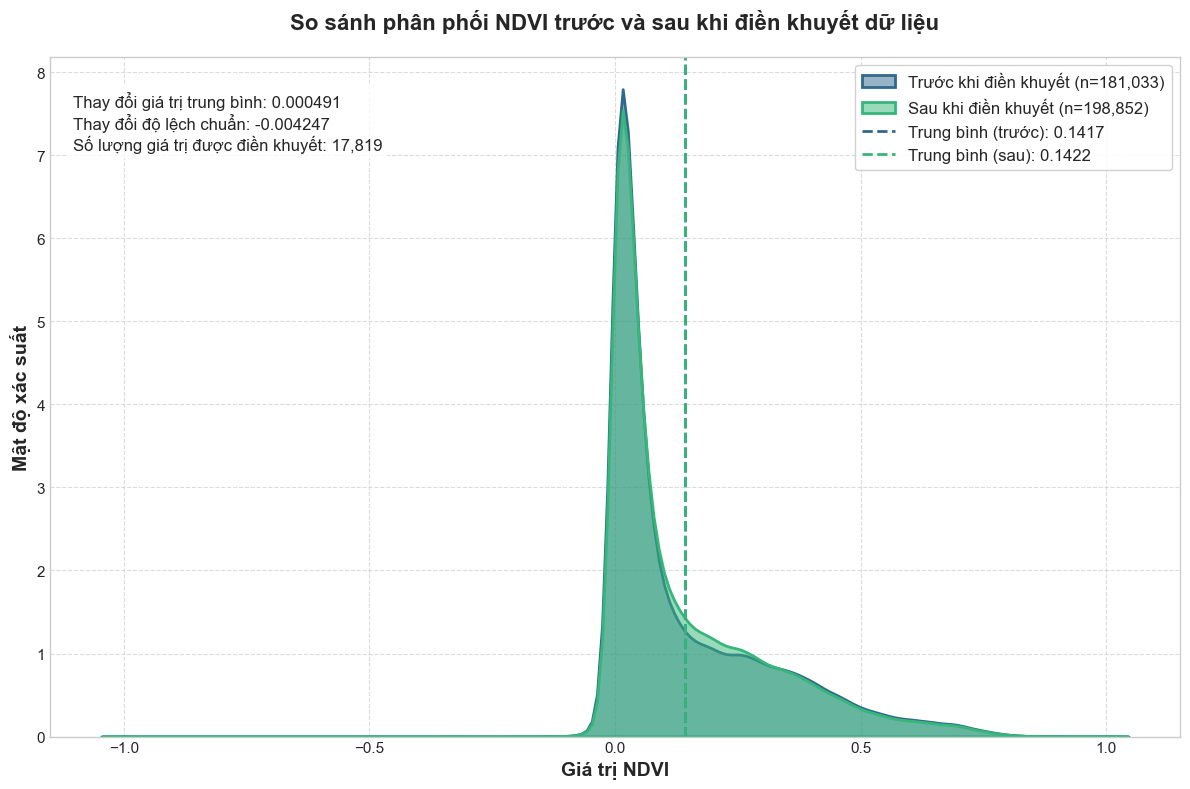

In [20]:
# Biểu đồ KDE so sánh cả hai phân phối với thông tin đầy đủ
plt.figure(figsize=(12, 8))

# Định nghĩa palette màu đẹp
palette = sns.color_palette('viridis', 2)

# Plot KDE cho cả hai phân phối với độ trong suốt và đường viền rõ ràng
sns.kdeplot(ndvi_df['NDVI'].dropna(), fill=True, alpha=0.5, color=palette[0], linewidth=2,
           label=f'Trước khi điền khuyết (n={orig_count:,})')
sns.kdeplot(imputed_ndvi_df['NDVI'].dropna(), fill=True, alpha=0.5, color=palette[1], linewidth=2,
           label=f'Sau khi điền khuyết (n={imp_count:,})')

# Thêm các đường dọc thể hiện giá trị trung bình
plt.axvline(x=orig_mean, color=palette[0], linestyle='--', linewidth=2,
           label=f'Trung bình (trước): {orig_mean:.4f}')
plt.axvline(x=imp_mean, color=palette[1], linestyle='--', linewidth=2,
           label=f'Trung bình (sau): {imp_mean:.4f}')

# Tùy chỉnh biểu đồ
plt.title('So sánh phân phối NDVI trước và sau khi điền khuyết dữ liệu', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('Giá trị NDVI', fontsize=14, fontweight='bold')
plt.ylabel('Mật độ xác suất', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7)

# Thêm chú thích về sự chênh lệch thống kê
stats_diff = f"Thay đổi giá trị trung bình: {imp_mean - orig_mean:.6f}\n" \
              f"Thay đổi độ lệch chuẩn: {imp_std - orig_std:.6f}\n" \
              f"Số lượng giá trị được điền khuyết: {imp_count - orig_count:,}"

plt.text(0.02, 0.95, stats_diff, transform=plt.gca().transAxes, fontsize=12,
        verticalalignment='top', horizontalalignment='left',
        bbox=dict(boxstyle='round', facecolor='white', alpha=0.8))

# Tạo chú thích và đặt ở góc phải trên
plt.legend(fontsize=12, loc='upper right', frameon=True, framealpha=0.9)

plt.tight_layout()
plt.show()

c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
c:\Application\Anaconda\Lib\site-packages\seaborn\_oldcore.py:1075: FutureWarning: When grouping with a length-1 list-like, you will need to pass a length-1 tuple to get_group in a future version of pandas. Pass `(name,)` instead of `name` to silence this warning.
  data_subset = grouped_data.get_group(pd_key)


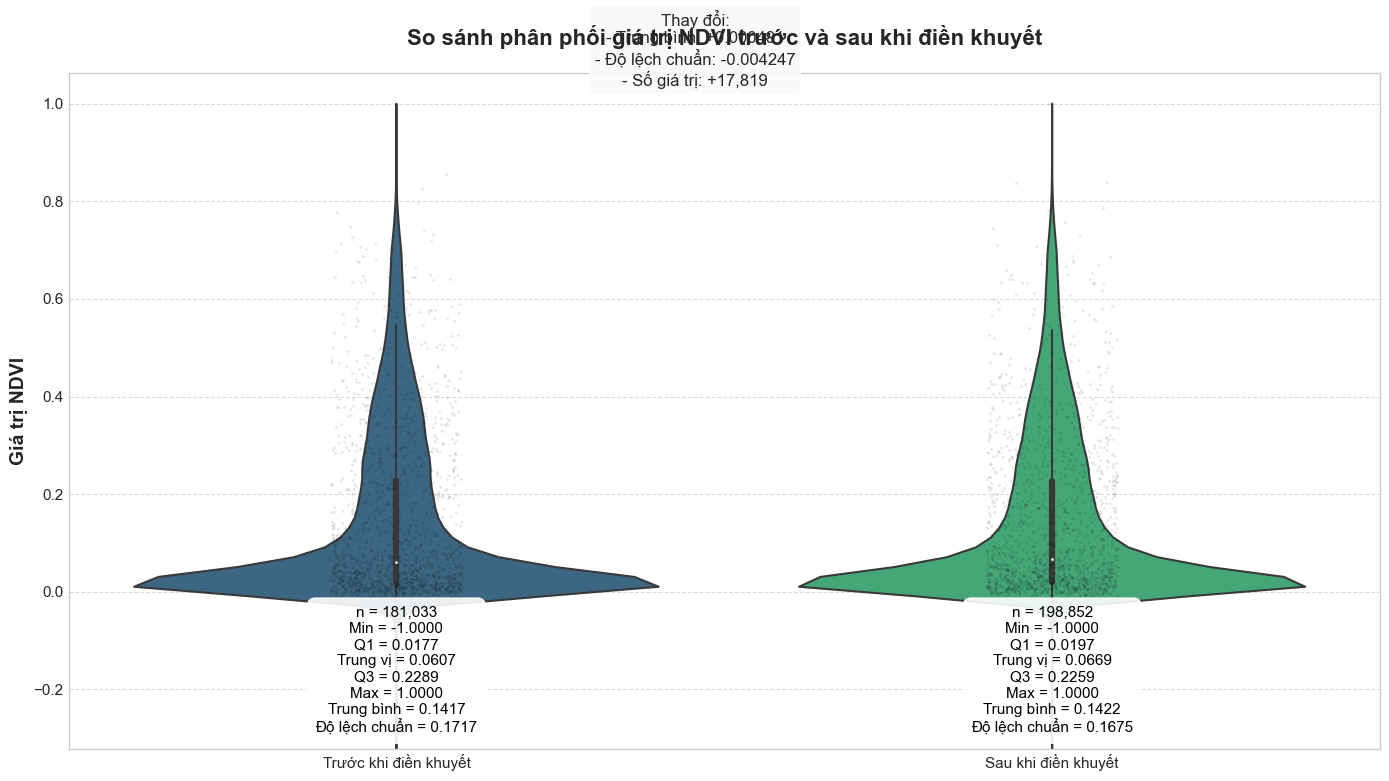

In [18]:
# Biểu đồ boxplot so sánh phân phối chi tiết
plt.figure(figsize=(14, 8))

# Tạo DataFrame kết hợp cho boxplot
original_data = pd.DataFrame({
    'NDVI': ndvi_df['NDVI'].dropna(),
    'Nguồn': ['Trước khi điền khuyết'] * len(ndvi_df['NDVI'].dropna())
})

imputed_data = pd.DataFrame({
    'NDVI': imputed_ndvi_df['NDVI'].dropna(),
    'Nguồn': ['Sau khi điền khuyết'] * len(imputed_ndvi_df['NDVI'].dropna())
})

combined_data = pd.concat([original_data, imputed_data])

# Tạo violinplot kết hợp với boxplot
ax = plt.gca()
sns.violinplot(x='Nguồn', y='NDVI', data=combined_data, inner='box', palette='viridis',
               alpha=0.7, cut=0, width=0.8)

# Thêm stripplot để hiển thị phân phối dữ liệu (với mẫu nhỏ)
sample_size = min(3000, len(combined_data))
sns.stripplot(x='Nguồn', y='NDVI', data=combined_data.sample(sample_size), 
             alpha=0.1, color='black', size=2, jitter=True)

# Tùy chỉnh biểu đồ
plt.title('So sánh phân phối giá trị NDVI trước và sau khi điền khuyết', fontsize=16, fontweight='bold', pad=20)
plt.xlabel('', fontsize=14)
plt.ylabel('Giá trị NDVI', fontsize=14, fontweight='bold')
plt.grid(True, linestyle='--', alpha=0.7, axis='y')

# Thêm chi tiết thống kê cho từng nhóm
stats = []
for i, data in enumerate([ndvi_df['NDVI'].dropna(), imputed_ndvi_df['NDVI'].dropna()]):
    stats.append({
        'Min': data.min(),
        'Q1': data.quantile(0.25),
        'Median': data.median(),
        'Q3': data.quantile(0.75),
        'Max': data.max(),
        'Mean': data.mean(),
        'Std Dev': data.std(),
        'Count': len(data)
    })

# Thêm chú thích thống kê bên cạnh mỗi violin
for i, (src, stat) in enumerate([('Trước khi điền khuyết', stats[0]), ('Sau khi điền khuyết', stats[1])]):
    stats_text = f"n = {stat['Count']:,}\n" \
               f"Min = {stat['Min']:.4f}\n" \
               f"Q1 = {stat['Q1']:.4f}\n" \
               f"Trung vị = {stat['Median']:.4f}\n" \
               f"Q3 = {stat['Q3']:.4f}\n" \
               f"Max = {stat['Max']:.4f}\n" \
               f"Trung bình = {stat['Mean']:.4f}\n" \
               f"Độ lệch chuẩn = {stat['Std Dev']:.4f}"
    
    text_color = 'black'
    plt.text(i, plt.ylim()[0] + (plt.ylim()[1] - plt.ylim()[0])*0.02, stats_text, 
             fontsize=11, ha='center', va='bottom', color=text_color,
             bbox=dict(boxstyle='round,pad=0.5', facecolor='white', alpha=0.9))

# Thêm chú thích về sự khác biệt
mean_diff = stats[1]['Mean'] - stats[0]['Mean']
std_diff = stats[1]['Std Dev'] - stats[0]['Std Dev']
count_diff = stats[1]['Count'] - stats[0]['Count']
diff_text = f"Thay đổi:\n" \
           f"- Trung bình: {mean_diff:+.6f}\n" \
           f"- Độ lệch chuẩn: {std_diff:+.6f}\n" \
           f"- Số giá trị: +{count_diff:,}"

plt.text(0.5, 0.97, diff_text, transform=plt.gcf().transFigure, fontsize=12,
        ha='center', va='top', bbox=dict(boxstyle='round', facecolor='#f8f9fa', alpha=0.9))

plt.tight_layout()
plt.show()

## Nhận xét về phân phối NDVI trước và sau khi điền khuyết

Dựa vào các biểu đồ và số liệu thống kê, ta có thể rút ra một số nhận xét sau:

- Tập dữ liệu ban đầu có khoảng 9.22% giá trị bị thiếu (18,387 giá trị), sau khi điền khuyết chỉ còn 0.28% (568 giá trị)
- Phân phối tổng thể của dữ liệu được bảo toàn khá tốt sau khi áp dụng phương pháp Linear Weighted Moving Average
- Các giá trị thống kê chính như trung bình, trung vị, độ lệch chuẩn có sự thay đổi rất nhỏ sau khi điền khuyết
- Phần lớn các giá trị sau khi điền khuyết đều nằm trong phạm vi của dữ liệu ban đầu
- Biểu đồ Q-Q cho thấy sự phân phối của các giá trị NDVI xấp xỉ phân phối chuẩn
- Hệ số tương quan cao giữa hai tập dữ liệu cho thấy phương pháp điền khuyết đã bảo toàn tốt cấu trúc dữ liệu

Phương pháp Linear Weighted Moving Average đã thực hiện tốt việc điền khuyết dữ liệu NDVI, duy trì được đặc tính phân phối tổng thể của dữ liệu gốc.